In [33]:
# install and import libraries
%%capture
!pip install ir_datasets
!pip install demoji

import re
import html
import string
import datetime as dt

import numpy as np
import pandas as pd
import ir_datasets
import demoji

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet as wn


from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from collections import Counter

pd.set_option('max_colwidth', 800)

In [34]:
# load dataset
dataset = ir_datasets.load("cord19/trec-covid")
print(f"queries: {dataset.queries_count()}, docs: {dataset.docs_count()}, qrels: {dataset.qrels_count()}")

queries: 50, docs: 192509, qrels: 69318


# Part 1: Analysis of Queries and Documents

In [35]:
%%capture
# convert the collection in a dataframe
queries = pd.DataFrame(dataset.queries_iter())
docs = pd.DataFrame(dataset.docs_iter())
qrels = pd.DataFrame(dataset.qrels_iter())

docs['date'] = pd.to_datetime(docs['date'])

In [ ]:
display(queries.sample(5))
display(docs.sample(5))
display(qrels.sample(5))

* numbers
* punctuation
* symbols
* whitespaces
* stop words
* HTML tags
* repeated characters
* URLs
* emojis

---

- stemming / lemmatization ?

## Preprocessing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  


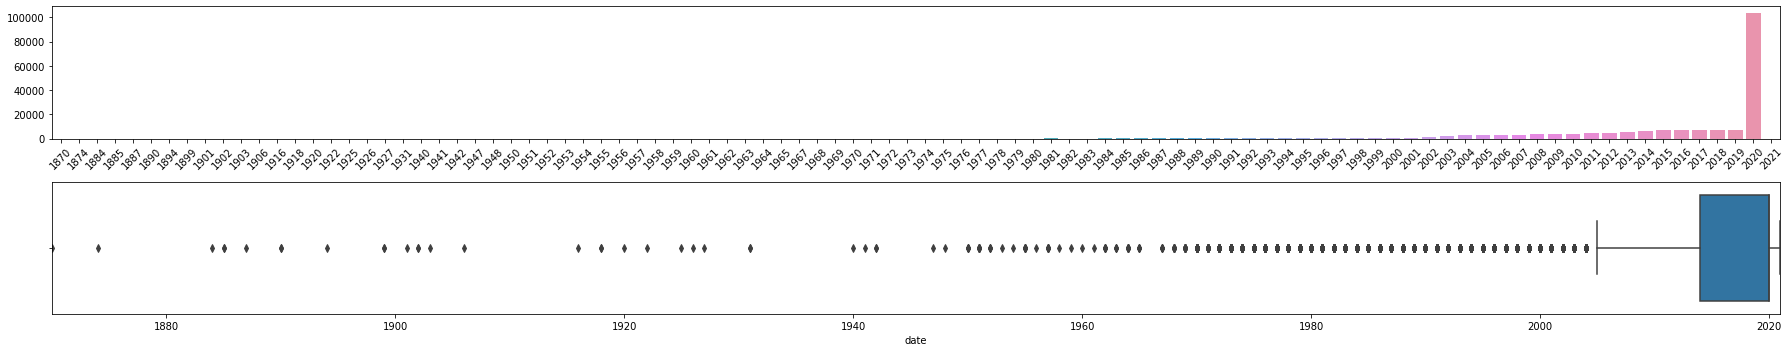

In [ ]:
years = docs["date"].dt.year
years.dropna(inplace=True)
years = years.astype(int)

u_years, u_counts = np.unique(years, return_counts=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

sns.barplot(x=u_years, y=u_counts, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)

sns.boxplot(x=years, ax=ax2, orient="h")
ax2.margins(0)

fig.tight_layout()

In [ ]:
emojis = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  e1 = demoji.findall(row["title"])
  if e1:
    for e in list(e1.keys()):
      emojis.add(e)
    # print(index, e1)

  e2 = demoji.findall(row["abstract"])
  if e2:
    for e in list(e2.keys()):
      emojis.add(e)
    # print(index, e2)

In [ ]:
emojis

{'©', '®', '™', '▪️', '♦️', '⬇️'}

In [ ]:
docs["abstract"][70663]

'Coronavirus EndoU inhibits dsRNA-activated antiviral responses; however, the physiologic RNA substrates of EndoU are unknown. In this study, we used mouse hepatitis virus (MHV)-infected bone-marrow-derived macrophage (BMM) and cyclic phosphate cDNA sequencing to identify the RNA targets of EndoU. EndoU targeted viral RNA, cleaving the 3′ side of pyrimidines with a strong preference for U⬇A and C⬇A sequences (endoY⬇A). EndoU-dependent cleavage was detected in every region of MHV RNA, from the 5′ NTR to the 3′ NTR, including transcriptional regulatory sequences (TRS). Cleavage at two CA dinucleotides immediately adjacent to the MHV poly(A) tail suggest a mechanism to suppress negative-strand RNA synthesis and the accumulation of viral dsRNA. MHV with EndoU (EndoUmut) or 2′-5′ phosphodiesterase (PDEmut) mutations provoked the activation of RNase L in BMM, with corresponding cleavage of RNAs by RNase L. The physiologic targets of EndoU are viral RNA templates required for negative-strand 

In [36]:
keywords = ["covid 19", "covid-19", "covid19", "sars-cov-2", "sarscov2", 
            "sars cov 2", "2019-nCoV", "Wuhan virus", "Chinese flu",
            "COronaVIrusDisease"]

keep = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  text = " ".join([row["title"], row["abstract"]])
  if any(re.findall(r'|'.join(keywords), text, re.IGNORECASE)):
    keep.add(index)

  # the few documents without date contain at least one keyword
  if row["date"] and row["date"] is not pd.NaT:
    if row["date"].year >= 2019:         
        if any(re.findall(r'coronavirus', " ".join([row["title"], row["abstract"]]), re.IGNORECASE)):
          keep.add(index)

print(f"{len(keep)}, {round(len(keep) / len(docs) * 100)}%")

docs = docs.iloc[list(keep)]

  0%|          | 0/192509 [00:00<?, ?it/s]

84048, 44%


In [37]:
def remove_urls(text):
    regex = "(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
    return re.sub(regex, '', text)

def remove_doi(text):
    regex = r"\b(doi:\s+)?(10[.][0-9]{4,}(?:[.][0-9]+)*(?:(?![\"&\'<>])\S)+)\b"
    return re.sub(regex, "", text)

# decidere se tenere qualche carattere
def remove_punctuation(text):
    punctuation = string.punctuation + '“”'
    return "".join([i for i in text if i not in punctuation])

def remove_extra_whitespace(text):
    return " ".join(text.split())

def replace_html_entities(text):
    return html.unescape(text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def remove_emojis(text):
    return demoji.replace(text)

def remove_numbers(text):
    pass


# il lemmatizer di wordnet ha solo questi 4 tag 
def pos2wordnet(nltk_pos):
  if nltk_pos.startswith('J'):
    return wn.ADJ
  elif nltk_pos.startswith('V'):
    return wn.VERB
  elif nltk_pos.startswith('N'):
    return wn.NOUN
  elif nltk_pos.startswith('R'):
    return wn.ADV
  else:
    return wn.NOUN


def preprocess(text):
  sentences = nltk.sent_tokenize(text)
  
  tokens_list = []
  for sent in sentences:
    sent = sent.lower()
    sent = remove_urls(sent)
    sent = remove_doi(sent)
    sent = remove_extra_whitespace(sent)
    sent = replace_html_entities(sent) # before removing punctuation (&\w+;)
    sent = remove_emojis(sent)
    sent = remove_punctuation(sent)
    sent = remove_stopwords(sent)

    tokens = nltk.word_tokenize(sent)
    tokens_list.append(tokens)

  tagged_tokens = nltk.pos_tag_sents(tokens_list)

  wnl = WordNetLemmatizer()

  result = []
  for tokens in tagged_tokens:
    for (token, pos) in tokens:
      t = wnl.lemmatize(token, pos2wordnet(pos))
      result.append(t)
    
  return result

In [40]:
text = docs["title"][4582]
x = preprocess(text)
text, x

('Therapeutic strategies in an outbreak scenario to treat the novel coronavirus originating in Wuhan, China',
 ['therapeutic',
  'strategy',
  'outbreak',
  'scenario',
  'treat',
  'novel',
  'coronavirus',
  'originate',
  'wuhan',
  'china'])

In [49]:
# global lists of tokens for wordclouds
titles = []
abstracts = []

docs_preprocessed = docs.copy()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  title_tokens = preprocess(row["title"])
  abstract_tokens = preprocess(row["abstract"])

  docs_preprocessed.loc[index, "title"] = ' '.join(title_tokens)
  docs_preprocessed.loc[index, "abstract"] = ' '.join(abstract_tokens)

  titles.extend(title_tokens)
  abstracts.extend(abstract_tokens)

  0%|          | 0/84048 [00:00<?, ?it/s]

In [ ]:
np.save("docs_processed", docs_preprocessed)

## Word Cloud

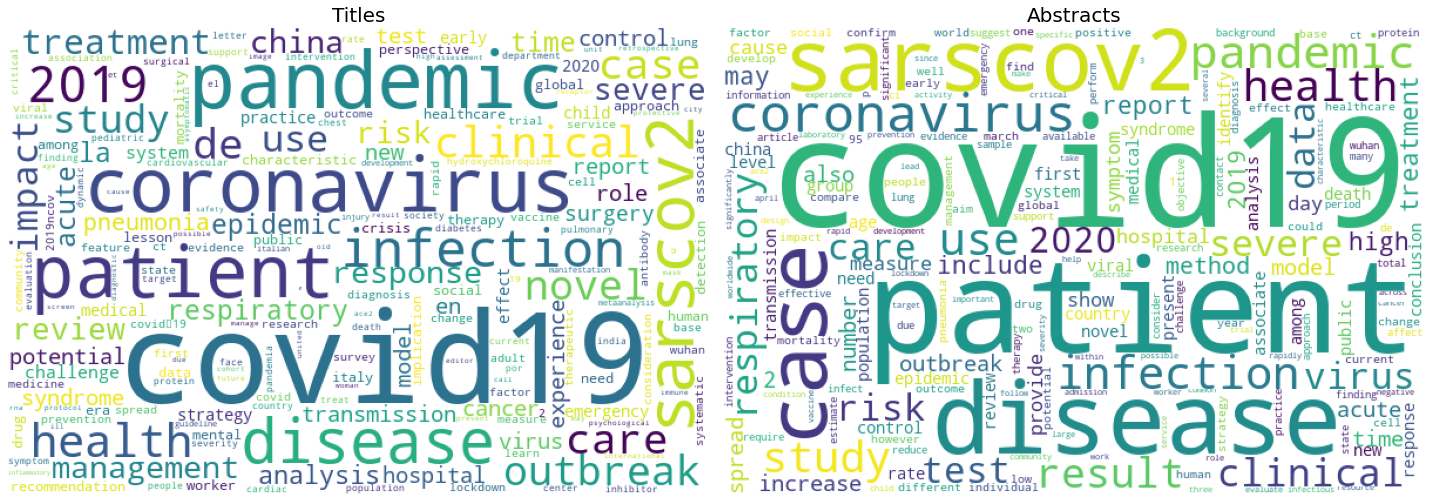

In [52]:
counter_title = Counter(titles)
counter_abstract = Counter(abstracts)

wc1 = WordCloud(collocations=False, background_color="white", width=600, height=400)
wc2 = WordCloud(collocations=False, background_color="white", width=600, height=400)

wc_titles = wc1.fit_words(counter_title)
wc_abstracts = wc2.fit_words(counter_abstract)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(wc_titles)
ax1.set_title("Titles", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_abstracts)
ax2.set_title("Abstracts", fontsize=20)
ax2.axis("off")

fig.tight_layout()

## Token Statistics

In [53]:
print("\n[Number of Tokens]")
print("Titles:", len(counter_title.keys()))
print("Abstracts:", len(counter_abstract.keys()))

k = 10
top_k_titles = [word for word, count in counter_title.most_common(k)]
top_k_abstracts = [word for word, count in counter_abstract.most_common(k)]

print(f"\n[Top {k} Most Common Tokens]")
print(f"Titles: {', '.join(top_k_titles)}")
print(f"Abstracts: {', '.join(top_k_abstracts)}")


[Number of Tokens]
Titles: 29896
Abstracts: 116349

[Top 10 Most Common Tokens]
Titles: covid19, pandemic, coronavirus, patient, sarscov2, disease, infection, 2019, health, clinical
Abstracts: covid19, patient, disease, sarscov2, case, coronavirus, pandemic, infection, use, study


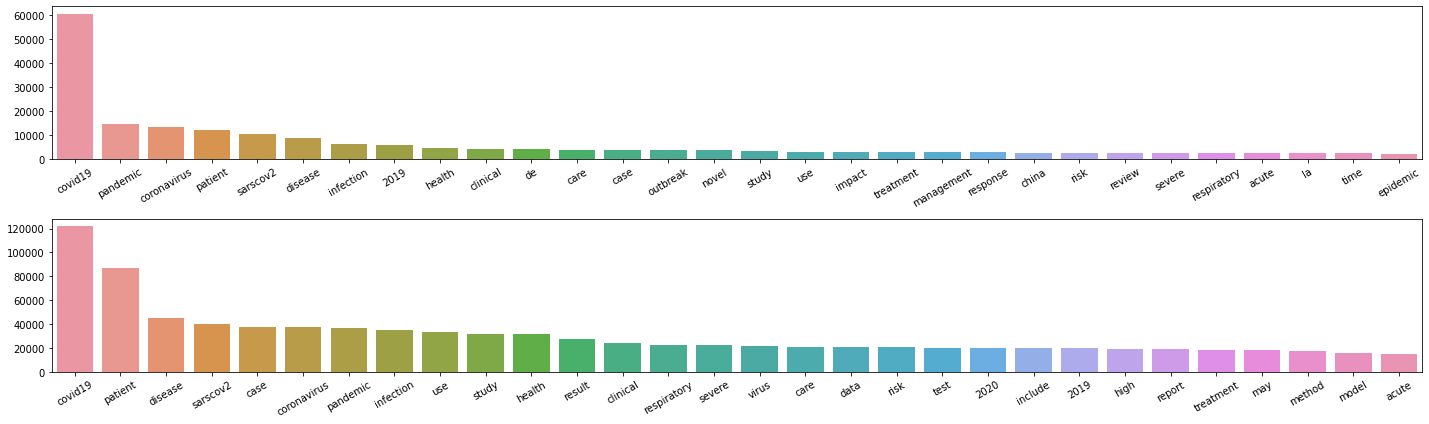

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 30

common_titles = dict(counter_title.most_common(k))
x_title = list(common_titles.keys())
y_title = list(common_titles.values())

common_abstracts = dict(counter_abstract.most_common(k))
x_abstract = list(common_abstracts.keys())
y_abstract = list(common_abstracts.values())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.barplot(x=x_title, y=y_title, ax=ax1)
sns.barplot(x=x_abstract, y=y_abstract, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 30)
fig.tight_layout()

# Part 2: Basic Search

# Part 3: Advanced Search (Optional)

# NOTE

prof: importate la precision. l'obiettivo é riportare la risposta migliore
